<img src="https://raw.githubusercontent.com/DavidScanu/oc-ai-engineer-p04-scoring/refs/heads/main/images/oc-banner-project-04-1660-v1.png" />

# Projet 4 - Construisez un modèle de scoring

## ⚙️ Installation et importation des bibliothèques nécessaires

In [1]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st # perform correlation calculation
import plotly.express as px

In [2]:
# Apply the default theme for seaborn
sns.set_theme()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
import os

# Check if the directory exists
if not os.path.exists('./content/data'):
    # Execute the commands if the directory does not exist
    os.system('wget "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip" -O temp.zip')
    os.system('mkdir -p ./content/data')
    os.system('unzip -o temp.zip -d ./content/data')
    os.system('rm temp.zip')
    os.system('rm -rf ./content/data/__MACOSX')
else:
    print("Directory ./content/data already exists.")

Directory ./content/data already exists.


In [5]:
data_folderpath = "./content/data/"

In [6]:
import os
import glob

def get_csv_filepaths(folder_path):
  """
  Returns a list of filepaths for all .csv files in the given folder.
  """
  csv_filepaths_dict = {}
  for filepath in glob.glob(os.path.join(folder_path, '*.csv')):
    filename = os.path.basename(filepath)
    filename = os.path.splitext(filename)[0]
    csv_filepaths_dict[filename] = filepath
  return csv_filepaths_dict

csv_files_dict = get_csv_filepaths(data_folderpath)

csv_files_df = pd.DataFrame(list(csv_files_dict.items()), columns=['filename', 'filepath']).sort_values(by='filename')
csv_files_df

,filename,filepath
4,HomeCredit_columns_description,./content/data/HomeCredit_columns_description.csv
5,POS_CASH_balance,./content/data/POS_CASH_balance.csv
2,application_test,./content/data/application_test.csv
8,application_train,./content/data/application_train.csv
0,bureau,./content/data/bureau.csv
3,bureau_balance,./content/data/bureau_balance.csv
1,credit_card_balance,./content/data/credit_card_balance.csv
9,installments_payments,./content/data/installments_payments.csv
7,previous_application,./content/data/previous_application.csv
6,sample_submission,./content/data/sample_submission.csv


In [7]:
import chardet

def csv_to_df(filepath):
  """
  Lit un seul fichier CSV dans un Pandas DataFrame, détectant l'encodage correct pour éviter les erreurs.

  - Args:
    - Le chemin du fichier .csv.
  - Returns:
    - Un DataFrame.
  """
  try:
    # Dectect file encoding
    with open(filepath, 'rb') as file:
      result = chardet.detect(file.read(10000))  # Analyze the first 10KB
      encoding = result['encoding']
      print(f"Detected encoding: {encoding}")
    # Read the .csv to a DataFrame
    df = pd.read_csv(filepath, encoding=encoding)
  except FileNotFoundError:
      print(f"Error: File not found at path: '{filepath}'.")
      # Handle the error appropriately (e.g., skip the file, raise an exception, etc.)
  except pd.errors.EmptyDataError:
      print(f"Error: Empty CSV file at path: '{filepath}'.")
      # Handle empty file error
  except pd.errors.ParserError:
      print(f"Error: ParserError while reading CSV at path: '{filepath}'.")
      # Handle parser error
  except Exception as e:  # Catch other potential errors during file reading
      print(f"An unexpected error occurred while reading '{filepath}': {e}")

  return df

In [8]:
application_train_raw = csv_to_df(csv_files_dict["application_train"])
print('Forme des données d’entraînement : ', application_train_raw.shape)
print()
application_train_raw.head()

Detected encoding: ascii
Forme des données d’entraînement :  (307511, 122)



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
application_train_raw.shape

(307511, 122)

## Split

In [30]:
y = application_train_raw['TARGET']
X = application_train_raw.drop('TARGET', axis=1)

In [31]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
print("Taille de X_train :", X_train.shape)
print("Taille de X_test :", X_test.shape)

Taille de X_train : (246008, 121)
Taille de X_test : (61503, 121)


In [33]:
def preparation(df):

  # Selection des variables
  features = [
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'EMERGENCYSTATE_MODE',
    'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'FLAG_MOBIL',
    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
    'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
    'OWN_CAR_AGE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED',
    'DAYS_LAST_PHONE_CHANGE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_MON', 'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_1',
    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
    'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'TOTALAREA_MODE',
    'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START'
  ]
  missing_columns = [col for col in features if col not in df.columns]
  if missing_columns:
    raise ValueError(f"Some columns are missing from the dataframe: {missing_columns}")
  df = df[features].copy()

  # Remplacez les valeurs manquantes par une modalité qui existe déjà
  df['FONDKAPREMONT_MODE'] = df['FONDKAPREMONT_MODE'].fillna('not specified')
  df['CODE_GENDER'] = df['CODE_GENDER'].fillna('XNA')
  df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna('Unaccompanied')

  # Remplissez les valeurs NaN de `OWN_CAR_AGE`
  # - Pour les propriétaires de voitures (1) : utiliser la médiane
  # - Pour les non-propriétaires de voitures (0) : utilisez 0
  # Never recalculate imputation parameters on test set
  median_car_age = df[df['FLAG_OWN_CAR'] == 'Y']['OWN_CAR_AGE'].median()
  df['OWN_CAR_AGE'] = df.apply(lambda row: median_car_age if row['FLAG_OWN_CAR'] == 'Y' else 0, axis=1)

  # Convertir les colonnes contenant les valeurs "Y" et "N" en 0 et 1 et remplir les valeurs manquantes avec 0
  df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1}).fillna(0).astype(int)
  df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1}).fillna(0).astype(int)
  df['EMERGENCYSTATE_MODE'] = df['EMERGENCYSTATE_MODE'].map({'No': 0, 'Yes': 1}).fillna(0).astype(int)

  # Correction des valeurs aberrantes dans les jours d'emploi (DAYS_EMPLOYED)
  # There are 55374 anomalous days of employment == 365243
  # Comme c'est une erreur (et non un outlier), nous allons imputer la médiane (plutot que de clip).
  if 'DAYS_EMPLOYED' in df.columns:
    # anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
    anom = df[df['DAYS_EMPLOYED'] > 25000]
    df['DAYS_EMPLOYED_ANOM'] = (df["DAYS_EMPLOYED"] > 25000).astype(int)  # Binary column (0 or 1)
    df.loc[df['DAYS_EMPLOYED'] > 25000, 'DAYS_EMPLOYED'] = np.nan  # Replace anomalies with NaN

  # Création de ratios
  # Debt to income ratio
  df['RATIO_DEBT_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
  # Annuity to income ratio
  df['RATIO_ANNUITY_INCOME'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
  # Annuity to credit ratio
  df['RATIO_ANNUITY_CREDIT'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
  # Days employed to age
  df['RATIO_DAYS_EMPLOYED_AGE'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

  # NAME_INCOME_TYPE : Combiner les types de revenus à faible nombre dans la modalité "Other".
  value_counts = df['NAME_INCOME_TYPE'].value_counts()
  low_count_categories = value_counts[value_counts < 100].index
  df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace(low_count_categories, 'Other')

  # CNT_CHILDREN : Créer une modalité qui regroupe "4 enfants et plus" (4).
  df.loc[df['CNT_CHILDREN'] >= 4, 'CNT_CHILDREN'] = 4

  # HOUR_APPR_PROCESS_START : Tranches d'heure pour `HOUR_APPR_PROCESS_START`.
  if 'HOUR_APPR_PROCESS_START' in df.columns:
    df['HOUR_GROUP'] = pd.cut(df['HOUR_APPR_PROCESS_START'], bins=[-1, 5, 11, 17, 23], labels=['Early Morning', 'Morning', 'Afternoon', 'Evening'])
    df.drop(columns=['HOUR_APPR_PROCESS_START'], inplace=True)

  # Conversion des variables catégorielles au dtype 'category'
  for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

  return df

In [34]:
X_train_prepared = preparation(X_train)
X_test_prepared = preparation(X_test)

In [35]:
# Categorical Columns
cat_cols = [
  'CODE_GENDER', 'NAME_CONTRACT_TYPE',
  'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
  'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
  'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
  'HOUR_GROUP'
]

# Binary Columns
binary_cols = [
  'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
  'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
  'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
  'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
  'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
  'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
  'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
  'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
  'DAYS_EMPLOYED_ANOM',
  'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE'
]

# Quantity Columns
quantity_cols = [
  'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
  'OWN_CAR_AGE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
  'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE',
  'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
  'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
  'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
  'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
  'AMT_REQ_CREDIT_BUREAU_MON',
  'RATIO_DEBT_INCOME', 'RATIO_ANNUITY_INCOME', 'RATIO_ANNUITY_CREDIT', 'RATIO_DAYS_EMPLOYED_AGE'
]

# Normalized Columns
normalized_cols = [
  'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
  'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
  'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
  'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
  'LANDAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
  'TOTALAREA_MODE'
]

# Rating Columns
rating_cols = [
  'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT'
]

In [36]:
# @title
def validate_dataframe_columns(df: pd.DataFrame, *column_lists) -> None:
  """
  Vérifiez que le DataFrame contient toutes les colonnes spécifiées et aucune colonne supplémentaire.

  Parameters:
      df (pd.DataFrame): Le DataFrame à valider.
      *column_lists (list of lists): N'importe quel nombre de listes contenant des noms de colonnes.
  """
  # Combine all column lists into a single list
  all_columns = [col for column_list in column_lists for col in column_list]

  # Rechercher les colonnes manquantes
  missing_columns = [col for col in all_columns if col not in df.columns]
  if missing_columns:
      print(f"Les colonnes suivantes sont manquantes dans le DataFrame : {missing_columns}")
  else:
      print("Toutes les colonnes spécifiées sont présentes dans le DataFrame.")

  # Rechercher des colonnes inattendues dans le DataFrame
  unexpected_columns = [col for col in df.columns if col not in all_columns]
  if unexpected_columns:
      print(f"Les colonnes suivantes sont dans le DataFrame mais pas dans les variables définies : {unexpected_columns}")
  else:
      print("Toutes les colonnes du DataFrame sont prises en compte dans les variables définies.")


validate_dataframe_columns(
  X_train_prepared,
  cat_cols,
  binary_cols,
  quantity_cols,
  normalized_cols,
  rating_cols
)

Toutes les colonnes spécifiées sont présentes dans le DataFrame.
Toutes les colonnes du DataFrame sont prises en compte dans les variables définies.


In [37]:
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pp_cat = Pipeline([
    ('cat_imp', SimpleImputer(strategy='constant', add_indicator=False, fill_value='missing')),
    ('cat_ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

pp_binary = Pipeline([
    ('binary_imp', SimpleImputer(strategy='constant', add_indicator=False, fill_value=0))
])

pp_quantity = Pipeline([
    ('quantity_imp', SimpleImputer(strategy='median', add_indicator=False)),
    ('quantity_scaler', RobustScaler()) # Traite les outliers
])

pp_normalized = Pipeline([
    ('normalized_imp', SimpleImputer(strategy='median', add_indicator=False))
])

pp_rating = Pipeline([
    ('rating_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
    ('rating_scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    # ('mi', MissingIndicator(), X_train_prepared.columns),
    ('pp_cat', pp_cat, cat_cols),
    ('pp_binary', pp_binary, binary_cols),
    ('pp_quantity', pp_quantity, quantity_cols),
    ('pp_normalized', pp_normalized, normalized_cols),
    ('pp_rating', pp_rating, rating_cols)
])


In [38]:
# Visualisation des données d'entraînement encodées
X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train_prepared))
print(X_train_preprocessed.shape)
X_train_preprocessed.head(2)

(246008, 196)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.035982,0.544616,-0.85,2.0,0.0,0.501564,0.452999,-0.554651,-1.047149,0.449074,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.695315,2.797233,-0.652438,1.431387,0.031329,0.286998,0.719454,0.735221,0.0876,0.0763,0.9816,0.7552,0.0211,0.0,0.1379,0.1667,0.2083,0.0481,0.0,0.0036,0.0687,0.5,0.5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.297452,0.419242,0.85,0.0,0.0,-0.852948,-0.753660,-0.651163,0.000000,-2.113426,0.0,0.5,0.5,0.0,0.0,0.0,2.5,0.0,0.0,-0.084902,-0.162091,-0.070099,0.000000,0.046220,0.505739,0.752656,0.609276,0.0876,0.0763,0.9816,0.7552,0.0211,0.0,0.1379,0.1667,0.2083,0.0481,0.0,0.0036,0.0687,0.0,0.0


In [39]:
# Visualisation des données de test encodées
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test_prepared))
print(X_test_preprocessed.shape)
X_test_preprocessed.head(2)

(61503, 196)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.419165,0.326271,0.35,1.0,0.0,0.797387,0.101619,0.417442,-0.263158,0.290123,0.0,3.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,-0.527874,0.072079,2.093865,0.77681,0.046220,0.378234,0.717734,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,0.0,0.1379,0.1667,0.2083,0.0481,0.0,0.0036,0.0687,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.480493,-0.862911,-0.75,0.0,0.0,-1.006292,-0.600228,-0.296899,0.000000,0.476080,0.0,0.0,0.0,0.0,0.0,0.0,1.5,2.0,0.0,-0.034076,-0.417737,-0.502509,0.00000,0.008474,0.505739,0.122652,0.793449,0.0619,0.0484,0.9821,0.7552,0.0000,0.0,0.1379,0.1667,0.2083,0.0379,0.0,0.0197,0.0469,0.5,0.5


In [40]:
from imblearn.over_sampling import SMOTE

print(y_train.value_counts()/len(y_train)*100)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Now you can use X_train_resampled and y_train_resampled for training your model

print(y_train_resampled.value_counts()/len(y_train_resampled)*100)
print(X_train_resampled.shape)
print(y_train_resampled.shape)

TARGET
0    91.940912
1     8.059088
Name: count, dtype: float64


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TARGET
0    50.0
1    50.0
Name: count, dtype: float64
(452364, 196)
(452364,)


#### Baseline

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

params = {
  'penalty' : ['none', 'l2', 'l1', 'elasticnet'],
  'C' : [float(x) for x in np.linspace(start=0, stop=1, num=75)]
}

# stratified kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
lr = LogisticRegression(solver="saga", max_iter=1000)

# search
grid_search = RandomizedSearchCV(
  lr,
  params,
  n_iter=10,
  scoring='roc_auc',
  cv=skf,
  n_jobs=-1,
  verbose=3,
  refit=True # refits best model to entire dataset
)

grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print(grid_search.cv_results_)

# Accédez au meilleur modèle à partir de la recherche par grille
best_model = grid_search.best_estimator_
# Predictions
y_pred = best_model.predict(X_test_preprocessed)
# Prédictions (probabilités)
y_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]
# Rapport de prédictions
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


: 

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculer l'AUC
roc_auc = roc_auc_score(y_test, y_proba)
print('ROC AUC: %.2f' % roc_auc)

In [23]:
from sklearn.metrics import precision_score

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
print(f"Precision for class 1: {precision_class_1}")

Precision for class 1: 0.15886461584187844


In [ ]:
from sklearn.metrics import recall_score

recall_lr = recall_score(y_test, y_pred)
print(f"Recall Score (Logistic Regression): {recall_lr}")

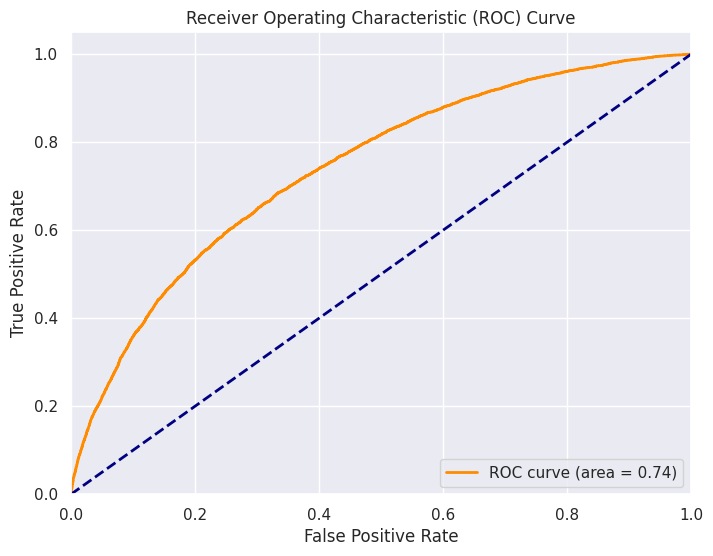

In [24]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

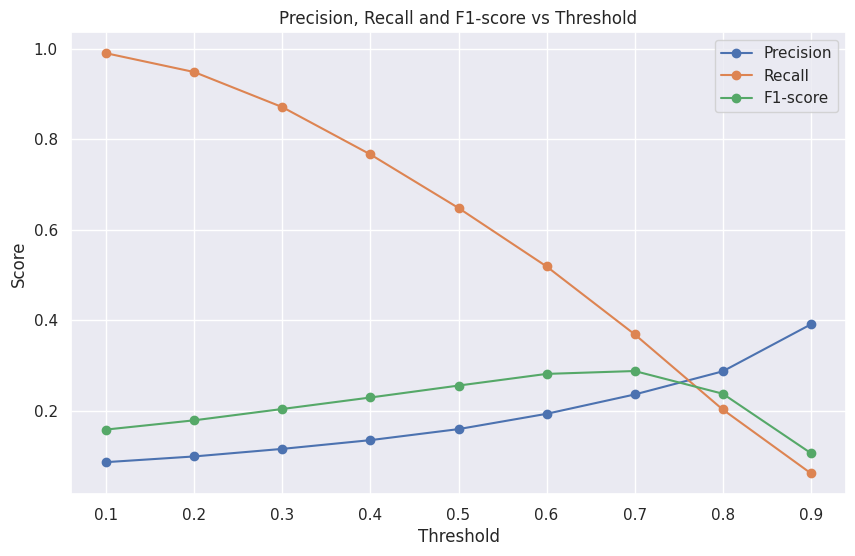

Threshold 0.1: Precision = 0.0858, Recall = 0.9903, F1-score = 0.1579
Threshold 0.2: Precision = 0.0984, Recall = 0.9487, F1-score = 0.1783
Threshold 0.3: Precision = 0.1151, Recall = 0.8711, F1-score = 0.2034
Threshold 0.4: Precision = 0.1345, Recall = 0.7664, F1-score = 0.2288
Threshold 0.5: Precision = 0.1589, Recall = 0.6480, F1-score = 0.2552
Threshold 0.6: Precision = 0.1927, Recall = 0.5187, F1-score = 0.2810
Threshold 0.7: Precision = 0.2355, Recall = 0.3686, F1-score = 0.2874
Threshold 0.8: Precision = 0.2867, Recall = 0.2023, F1-score = 0.2372
Threshold 0.9: Precision = 0.3905, Recall = 0.0612, F1-score = 0.1059


In [25]:
# prompt: Visualisation de precision recall F1 score sur le meme graphique en fonction du seuil
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def precision_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate precision
    precision = precision_score(y_true, y_pred, pos_label=1)
    return precision

def recall_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate recall
    recall = recall_score(y_true, y_pred, pos_label=1)
    return recall

def f1_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate f1-score
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return f1

# Calculate precision, recall and f1-score for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = [precision_at_threshold(y_test, y_proba, t) for t in thresholds]
recalls = [recall_at_threshold(y_test, y_proba, t) for t in thresholds]
f1_scores = [f1_at_threshold(y_test, y_proba, t) for t in thresholds]


# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls, marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1-score')
plt.title('Precision, Recall and F1-score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Print the results
for threshold, precision, recall, f1 in zip(thresholds, precisions, recalls, f1_scores):
    print(f"Threshold {threshold}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1-score = {f1:.4f}")

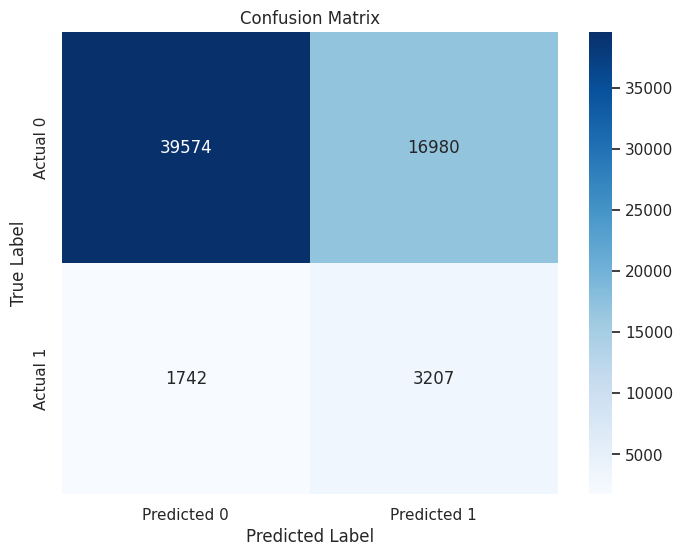

In [26]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_test' and 'y_pred' are defined from the previous code
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### GridSearchCV

- Paramètres de penalisation (L1, L2)
- Forces de régularisation (C) : L'espacement logarithmique garantit que la recherche couvre de manière exhaustive les petites et les grandes valeurs

In [29]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Classificateur
lr = LogisticRegression()

# Créer un pipeline avec préprocesseur et classificateur
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# Hyperparameter Tuning with GridSearchCV
param_grid = {
  'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
  'classifier__C': np.logspace(-4, 4, 20),
  'classifier__solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
  'classifier__max_iter': [1000, 2000]
}

# Create GridSearchCV with the pipeline
grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=5, # Define the StratifiedKFold cross-validator
    scoring='roc_auc',
    refit=True,
    n_jobs=-1,
    verbose=3
)

# Fit GridSearchCV
grid_search.fit(X_train_prepared, y_train)

# Best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print(grid_search.cv_results_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=lbfgs;, score=nan total time=   5.8s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=newton-cg;, score=nan total time=   5.8s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=lbfgs;, score=nan total time=   6.0s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=newton-cg;, score=nan total time=   5.9s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=lbfgs;, score=nan total time=   8.1s
[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=lbfgs;, score=nan total time=   8.2s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__pe

/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=  14.3s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   6.6s
[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=  10.3s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=  19.1s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=  20.0s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=  20.4s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.674 total time=   7.0s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.672 total time=   8.5s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.677 total time=   8.3s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  20.8s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  20.7s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  22.2s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  19.3s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.682 total time=   9.5s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.681 total time=  10.7s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  24.0s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.672 total time=  19.8s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.677 total time=  18.2s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.674 total time=  18.2s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.662 total time=  16.5s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.681 total time=  18.2s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.661 total time=  16.6s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.681 total time=  24.0s
[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.670 total time=  10.4s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.666 total time=  10.3s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.665 total time=  17.1s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=sag;, score=0.672 total time= 1.9min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=sag;, score=0.681 total time= 1.9min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=sag;, score=0.677 total time= 2.0min
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=sag;, score=0.674 total time= 2.0min
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, score=nan total time=   3.6s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, score=nan total time=   4.6s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, score=nan total time=   5.6s
[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, score=nan total time=   5.4s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=lbf

/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=   7.9s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=   7.5s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=  10.1s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=   9.5s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.500 total time=  12.1s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   7.1s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   4.2s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   5.5s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   3.8s
[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   5.2s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  15.0s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  17.6s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  17.4s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.672 total time=   8.6s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  15.2s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.677 total time=   7.3s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.674 total time=   5.3s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l1, classifier__solver=saga;, score=0.500 total time=  21.5s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.681 total time=   5.7s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.682 total time=   7.7s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.677 total time=  10.0s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.672 total time=  12.8s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.674 total time=  11.4s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.681 total time=  11.0s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.662 total time=  11.0s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.681 total time=  15.3s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.661 total time=   9.7s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.665 total time=   8.5s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.670 total time=   8.2s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.666 total time=   8.0s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga;, score=0.672 total time= 6.1min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga;, score=0.677 total time= 6.7min
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=sag;, score=0.672 total time= 2.0min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=sag;, score=0.677 total time= 2.1min
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=sag;, score=0.674 total time= 2.1min
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga;, score=0.674 total time= 7.4min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=sag;, score=0.681 total time= 1.9min
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga;, score=0.681 total time= 6.6min
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, score=nan total time=   3.0s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=sag;, score=0.681 total time= 1.8min
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, score=nan total time=   3.4s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, score=nan total time=   3.3s
[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=lbfgs;, sc

/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga;, score=0.681 total time= 7.1min
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=liblinear;, score=nan total time=   3.4s
[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=liblinear;, score=nan total time=   3.3s
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=liblinear;, score=nan total time=   3.8s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=sag;, score=nan total time=   3.5s
[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, classifier__solver=sag;, score=nan total time=   3.7s
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=elasticnet, class

/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.582 total time=  14.1s
[CV 2/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.582 total time=  14.4s
[CV 1/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   4.0s
[CV 2/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   4.0s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.580 total time=  12.2s
[CV 5/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=liblinear;, score=0.578 total time=  10.6s
[CV 3/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   4.3s
[CV 5/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   4.4s
[CV 4/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   6.6s
[CV 1/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.573 total time=  58.6s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.580 total time= 1.1min
[CV 3/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.583 total time= 1.2min
[CV 1/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.691 total time=   6.2s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.695 total time=   5.8s
[CV 3/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.691 total time=   5.6s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.700 total time=   8.2s
[CV 5/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.700 total time=   6.1s
[CV 1/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.691 total time=   8.9s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.580 total time= 1.1min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.695 total time=  12.5s
[CV 5/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga;, score=0.578 total time= 1.1min
[CV 3/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.691 total time=  10.9s
[CV 1/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.695 total time=   8.4s
[CV 5/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.700 total time=  10.9s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=newton-cg;, score=0.700 total time=  17.6s
[CV 3/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.695 total time=   6.6s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.695 total time=   7.9s


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.703 total time=   7.3s
[CV 5/5] END classifier__C=0.00026366508987303583, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=liblinear;, score=0.702 total time=   6.0s
[CV 1/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=saga;, score=0.672 total time= 6.6min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=saga;, score=0.677 total time= 6.5min
[CV 3/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=saga;, score=0.674 total time= 6.4min


/home/david/projects/openclassrooms/projets/oc-ai-engineer-p04-scoring/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=saga;, score=0.681 total time= 7.1min
[CV 5/5] END classifier__C=0.0001, classifier__max_iter=2000, classifier__penalty=l2, classifier__solver=saga;, score=0.681 total time= 7.0min


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

# Accédez au meilleur modèle à partir de la recherche par grille
best_model = grid_search.best_estimator_
# Predictions
y_pred = best_model.predict(X_test_prepared)
# Prédictions (probabilités)
y_proba = best_model.predict_proba(X_test_prepared)[:, 1]
# Rapport de prédictions
print(classification_report(y_test, y_pred))

In [114]:
from sklearn.metrics import roc_auc_score

roc_auc_lr = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score (Logistic Regression): {roc_auc_lr}")

ROC AUC Score (Logistic Regression): 0.7475202613569324


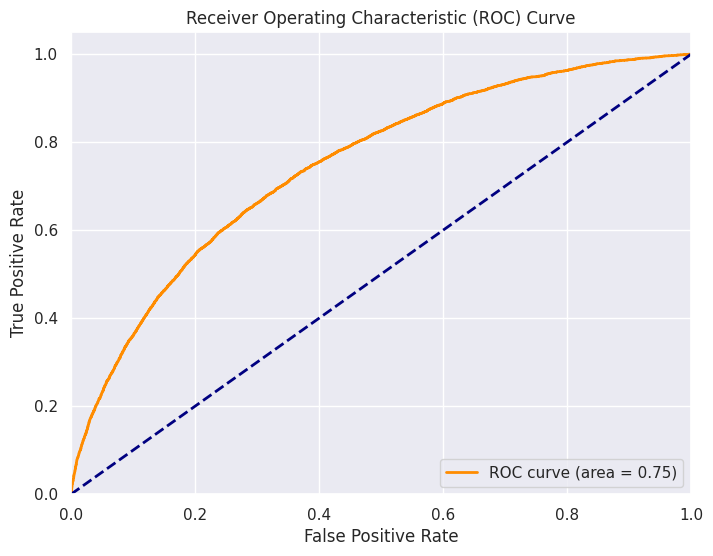

In [115]:
# prompt: Visualisation de ROC AUC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred_proba_lr are defined from the previous code

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

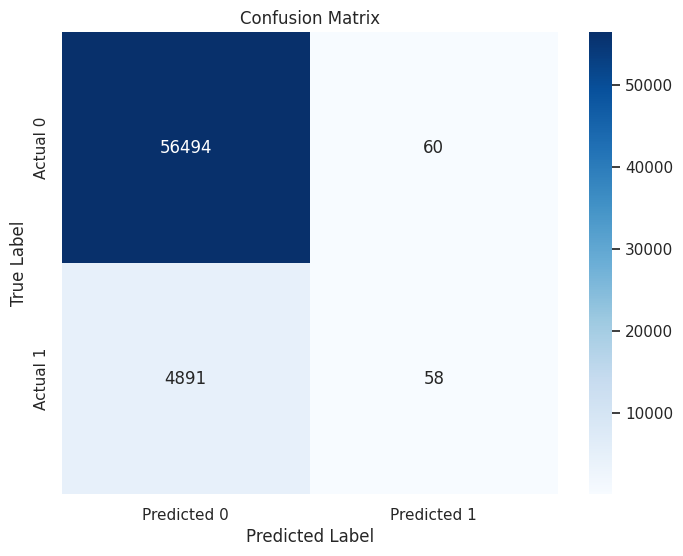

In [116]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_test' and 'y_pred' are defined from the previous code
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [117]:
from sklearn.metrics import precision_score

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
print(f"Precision for class 1: {precision_class_1}")

Precision for class 1: 0.4915254237288136


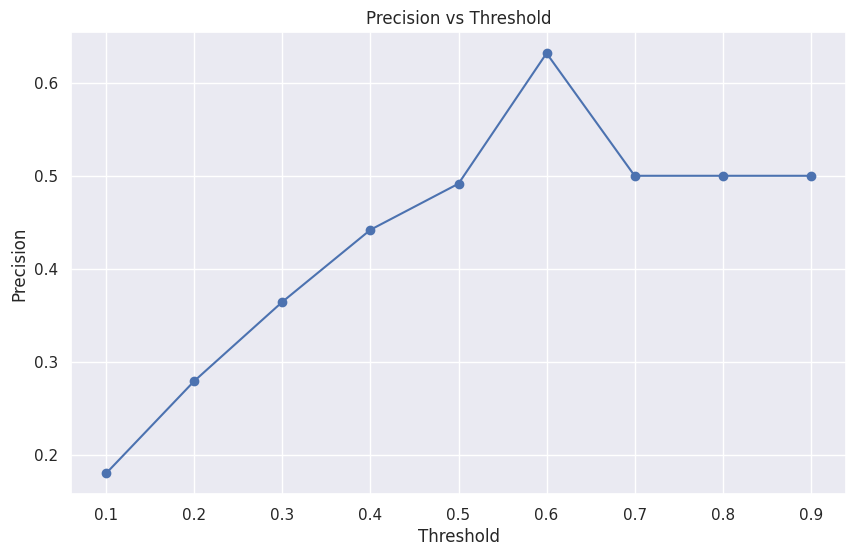

Threshold 0.1: Precision = 0.1806
Threshold 0.2: Precision = 0.2796
Threshold 0.3: Precision = 0.3646
Threshold 0.4: Precision = 0.4420
Threshold 0.5: Precision = 0.4915
Threshold 0.6: Precision = 0.6316
Threshold 0.7: Precision = 0.5000
Threshold 0.8: Precision = 0.5000
Threshold 0.9: Precision = 0.5000


In [118]:
# Function to calculate precision at different thresholds
def precision_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision
    precision = precision_score(y_true, y_pred, pos_label=1)

    return precision

# Calculate precision for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = [precision_at_threshold(y_test, y_proba, t) for t in thresholds]

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, marker='o')
plt.title('Precision vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Print the results
for threshold, precision in zip(thresholds, precisions):
    print(f"Threshold {threshold}: Precision = {precision:.4f}")

In [ ]:
from sklearn.metrics import recall_score

recall_lr = recall_score(y_test, y_pred)
print(f"Recall Score (Logistic Regression): {recall_lr}")

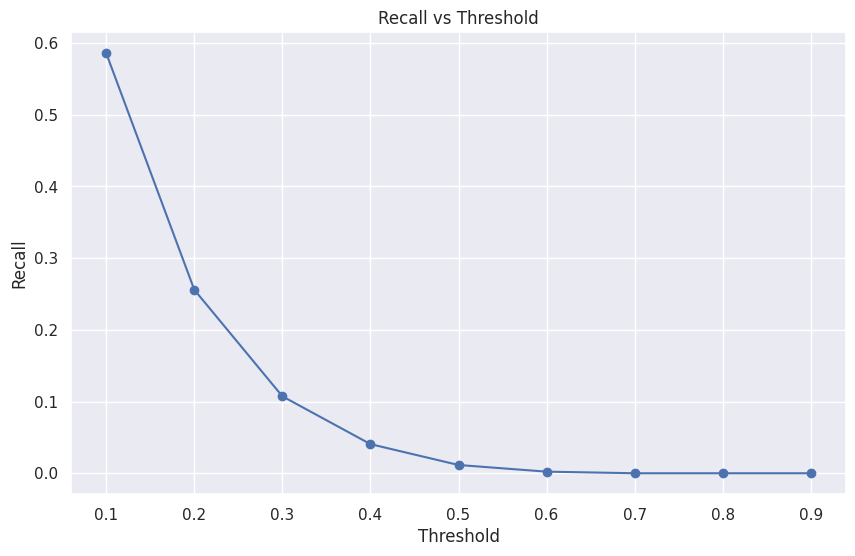

Threshold 0.1: Recall = 0.5858
Threshold 0.2: Recall = 0.2560
Threshold 0.3: Recall = 0.1075
Threshold 0.4: Recall = 0.0408
Threshold 0.5: Recall = 0.0117
Threshold 0.6: Recall = 0.0024
Threshold 0.7: Recall = 0.0002
Threshold 0.8: Recall = 0.0002
Threshold 0.9: Recall = 0.0002


In [120]:
# Function to calculate recall at different thresholds
def recall_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate recall
    recall = recall_score(y_true, y_pred, pos_label=1)

    return recall

# Calculate recall for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
recalls = [recall_at_threshold(y_test, y_proba, t) for t in thresholds]

# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, marker='o')
plt.title('Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Print the results
for threshold, recall in zip(thresholds, recalls):
    print(f"Threshold {threshold}: Recall = {recall:.4f}")

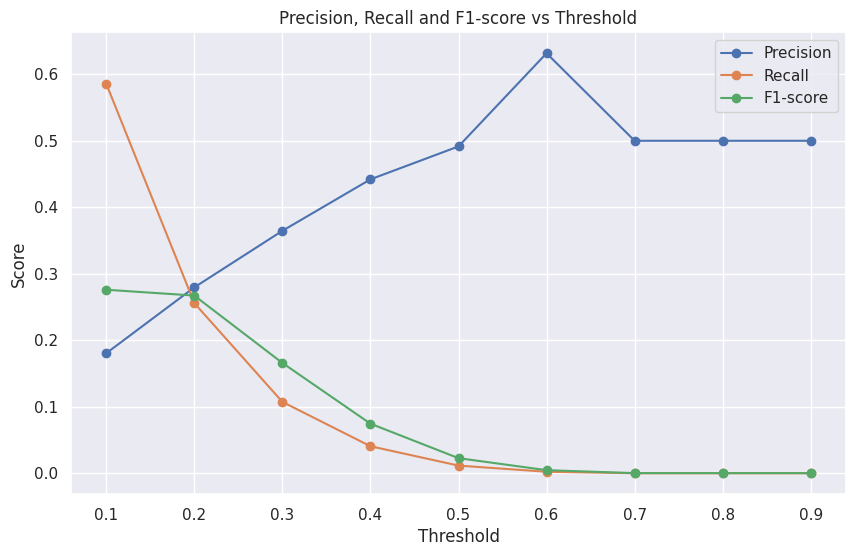

Threshold 0.1: Precision = 0.1806, Recall = 0.5858, F1-score = 0.2761
Threshold 0.2: Precision = 0.2796, Recall = 0.2560, F1-score = 0.2673
Threshold 0.3: Precision = 0.3646, Recall = 0.1075, F1-score = 0.1660
Threshold 0.4: Precision = 0.4420, Recall = 0.0408, F1-score = 0.0747
Threshold 0.5: Precision = 0.4915, Recall = 0.0117, F1-score = 0.0229
Threshold 0.6: Precision = 0.6316, Recall = 0.0024, F1-score = 0.0048
Threshold 0.7: Precision = 0.5000, Recall = 0.0002, F1-score = 0.0004
Threshold 0.8: Precision = 0.5000, Recall = 0.0002, F1-score = 0.0004
Threshold 0.9: Precision = 0.5000, Recall = 0.0002, F1-score = 0.0004


In [123]:
# prompt: Visualisation de precision recall F1 score sur le meme graphique en fonction du seuil
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def precision_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate precision
    precision = precision_score(y_true, y_pred, pos_label=1)
    return precision

def recall_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate recall
    recall = recall_score(y_true, y_pred, pos_label=1)
    return recall

def f1_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate f1-score
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return f1

# Calculate precision, recall and f1-score for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = [precision_at_threshold(y_test, y_proba, t) for t in thresholds]
recalls = [recall_at_threshold(y_test, y_proba, t) for t in thresholds]
f1_scores = [f1_at_threshold(y_test, y_proba, t) for t in thresholds]


# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls, marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1-score')
plt.title('Precision, Recall and F1-score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Print the results
for threshold, precision, recall, f1 in zip(thresholds, precisions, recalls, f1_scores):
    print(f"Threshold {threshold}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1-score = {f1:.4f}")

### LightGBM

- https://stackoverflow.com/questions/49606886/installing-gpu-support-for-lightgbm-on-google-colab/77078844#77078844

In [ ]:
!pip install dask[dataframe] --quiet
!pip uninstall lightgbm -y --quiet
!pip install lightgbm --config-settings=cmake.define.USE_CUDA=ON --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.1 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
print("LightGBM version:", lgb.__version__)

LightGBM version: 4.5.0


In [ ]:
list(range(len(cat_cols)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#### Test

- No preprocessing

In [ ]:
from lightgbm import LGBMClassifier

# Create a LightGBM classifier
model = LGBMClassifier(
    num_leaves=31,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary',
    is_unbalance=True,
    metric='auc',
    random_state=42,
    # categorical_feature=cat_cols,
    verbose=1
)

# Fit the model
model.fit(X_train_prepared, y_train)

# Predict
predictions = model.predict(X_test_prepared)

# Feature importance
print(model.feature_importances_)

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.240797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6828
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[ 31   1  36   0  36   9   5  24  28  12 101 643   0   0  10   0   0  13
   0   4   0   0   2   0  11   0   0   0  15   0   0   1   0   1   0   0
   1   0   6   2   1   8   0   4   0   0   0  69  77  33   1   0 106  42
  78  56  57  24  12   3   1   2   6  30  25   9  28 185 145 175  32  32
  27  18  29   7  24  24  16  30  18  21  31  22   2   0  48  51 348  46
   5]


In [ ]:
X_train_prepared.shape

(246008, 91)

In [ ]:
len(model.feature_importances_)

91

In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train_prepared.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:30]

# Display the DataFrame
feature_importance_df

,Feature,Importance
11,ORGANIZATION_TYPE,643
88,RATIO_ANNUITY_CREDIT,348
67,EXT_SOURCE_1,185
69,EXT_SOURCE_3,175
68,EXT_SOURCE_2,145
52,DAYS_BIRTH,106
10,OCCUPATION_TYPE,101
54,DAYS_ID_PUBLISH,78
48,AMT_ANNUITY,77
47,AMT_CREDIT,69


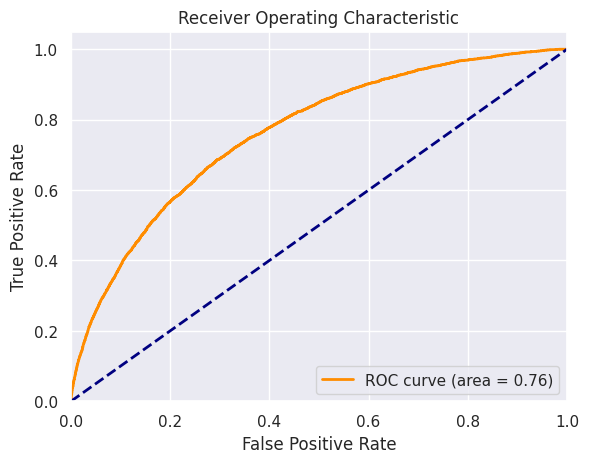

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test contains the true labels for the test set
# and predictions_proba contains the predicted probabilities for the positive class

y_pred_proba = model.predict_proba(X_test_prepared)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

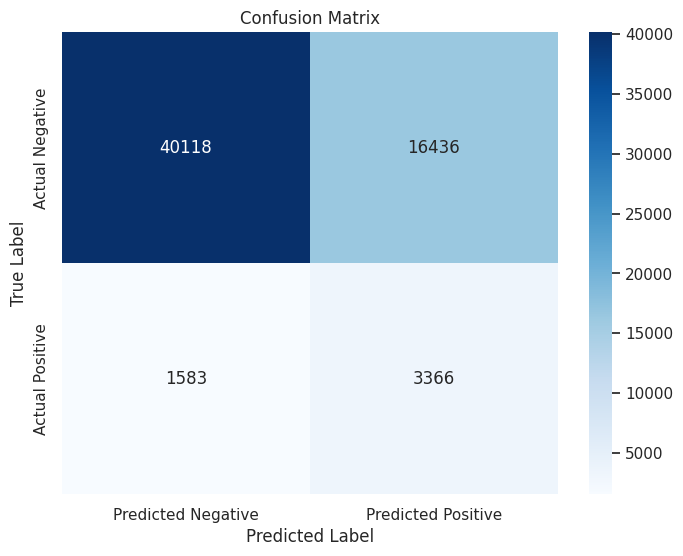

In [ ]:
# prompt: confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'y_test' contains the true labels and 'predictions' contains the predicted labels
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Simple

In [ ]:
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pp_cat = Pipeline([
    ('cat_imp', SimpleImputer(strategy='constant', add_indicator=False, fill_value='missing')),
    ('cat_le', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    # ('ohe_cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

pp_binary = Pipeline([
    ('binary_imp', SimpleImputer(strategy='constant', add_indicator=False, fill_value=0))
])

pp_quantity = Pipeline([
    ('quantity_imp', SimpleImputer(strategy='median', add_indicator=False)),
    # ('quantity_rob', RobustScaler())
])

pp_normalized = Pipeline([
    ('normalized_imp', SimpleImputer(strategy='median', add_indicator=False))
])

pp_rating = Pipeline([
    ('rating_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
    # ('rating_rob', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    # ('mi', MissingIndicator(), X_train_prepared.columns),
    ('pp_cat', pp_cat, cat_cols),
    ('pp_binary', pp_binary, binary_cols),
    ('pp_quantity', pp_quantity, quantity_cols),
    ('pp_normalized', pp_normalized, normalized_cols),
    ('pp_rating', pp_rating, rating_cols)
])

# Apply the transformations to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train_prepared)

# Check the result (optional)
print(pd.DataFrame(X_train_preprocessed).shape)
pd.DataFrame(X_train_preprocessed).head(2)

(246008, 91)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,0.0,0.0,6.0,2.0,4.0,5.0,1.0,18.0,57.0,0.0,1.0,7.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,555273.0,16366.5,171000.0,0.0,9.0,-23349.0,-3595.0,-4408.0,-1646.0,-2058.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.247211,0.095711,0.029475,0.118507,0.035792,0.524685,0.358568,0.563835,0.0876,0.0763,0.9821,0.7552,0.0211,0.0,0.1379,0.1667,0.2083,0.0483,0.0000,0.0035,0.0687,2.0,2.0
1,1.0,0.0,6.0,4.0,4.0,1.0,1.0,8.0,4.0,2.0,0.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,198085.5,23638.5,157500.0,1.0,0.0,-10921.0,-4281.0,-3399.0,-117.0,-73.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.257686,0.150086,0.119335,0.010713,0.010032,0.244926,0.490305,0.595456,0.0784,0.0633,0.9742,0.6464,0.0266,0.0,0.1379,0.1667,0.2083,0.0409,0.0039,0.0149,0.0645,2.0,2.0


In [ ]:
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from lightgbm import LGBMClassifier


# LightGBM classifier
lgbm = LGBMClassifier(
  objective='binary',
  is_unbalance=True,
  random_state=42,
  # categorical_feature=list(range(len(cat_cols))),
  # categorical_feature=cat_cols,
  n_jobs =-1,
  verbose=1,
)

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm)
])

In [ ]:
# Fit the pipeline
pipeline.fit(X_train_prepared, y_train)

# Predict on the test set
predictions = pipeline.predict(X_test_prepared)

# Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test_prepared)[:,1]

# Evaluate the model (example: ROC AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc}")

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6760
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
ROC AUC: 0.7644667763823886


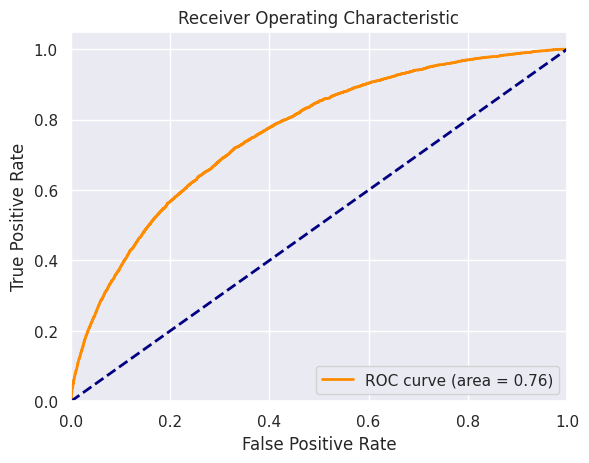

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

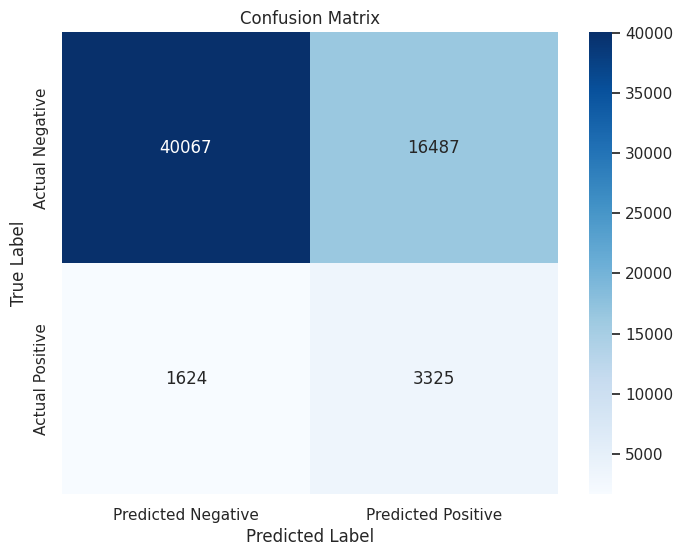

In [ ]:
# prompt: Confusion matrix

# Assuming 'y_test' contains the true labels and 'predictions' contains the predicted labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### GridSearchCV

In [ ]:
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from lightgbm import LGBMClassifier


# LightGBM classifier
lgbm = LGBMClassifier(
  objective='binary',
  is_unbalance=True,
  random_state=42,
  # categorical_feature=list(range(len(cat_cols))),  # Use indices of categorical columns
  categorical_feature=cat_cols,
  n_jobs =-1,
  verbose=1,
)

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm)
])

# Parameter grid for GridSearchCV
param_grid = {
  'classifier__num_leaves': [31, 50, 100],  # Add more options
  'classifier__learning_rate': [0.01, 0.05, 0.1],  # More learning rate options
  'classifier__n_estimators': [100, 200, 300],  # More estimator options
  'classifier__max_depth': [-1, 5, 10],  # Consider adding max_depth
  'classifier__min_child_samples': [20, 50, 100]  # Add child samples parameter
}


# Custom scorer for ROC AUC
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, response_method="predict_proba")

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring=roc_auc_scorer
)

# Fit GridSearchCV
grid_search.fit(X_train_prepared, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score on Training Set:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC on Test Set:", test_roc_auc)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming you have y_test and y_pred_proba from the previous code
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Arbre de décision

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc_pipeline = Pipeline([
    ('ct_step', ct),
    ('model', DecisionTreeClassifier())
])

dtc_pipeline.fit(X_train_prepared, y_train)
dtc_predictions = dtc_pipeline.predict(X_test_prepared)

print("Decision Tree Classifier Results:")
print(classification_report(y_test, dtc_predictions))

Decision Tree Classifier Results:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     56554
           1       0.15      0.17      0.16      4949

    accuracy                           0.85     61503
   macro avg       0.54      0.54      0.54     61503
weighted avg       0.86      0.85      0.86     61503



In [ ]:
from sklearn.metrics import roc_auc_score

# Assuming y_test contains the true labels and dtc_predictions contains the predicted probabilities
y_pred_proba = dtc_pipeline.predict_proba(X_test_prepared)[:, 1]  # Probability of the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.5418674697353113


## 📈 Étape 2 - Définissez une métrique adaptée à la problématique métier

- Une **fonction de coût métier** mise en place prenant en compte les coûts des faux positifs et des faux négatifs.
- Un score "métier" calculé pour évaluer les performances des différents modèles.

`TARGET` : 1 est "mauvais payeur".

Le modèle prédictif retourne une probabilité que la personne soit un "mauvais payeur" (`TARGET`: 1).

- **Faux positif** : "Mauvais payeur" alors que bon client (moins grave, manque à gagner pour la banque).
- **Faux négatif** : "Bon payeur" alors que "mauvais payeur" (grave pour la banque, risque élevé de ne pas rembourser)


Performance
- ROC AUC : Choix du modèle
- Cout métier : pour déterminer le seuil de refus à partir duquel un client est déclaré "mauvais client". Courbe de (FP + 10 FN) pour chaque valeur de seuil de refus.

**Calcul cout métier :**
- Probabilités prédites
- Seuil
- Classer les bons / mauvais payeurs
- Comparer avec y_test
- Cout métier = FN + (10 x FP)
- Repeter l'opération pour plusieurs seuils
- Tracer la courber
- Trouver le seuil optimal




Ressources :
- https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning

If you want to **avoid false negatives**, you should use a metric that emphasizes the ability of the model to correctly identify **positive cases**. Avoiding false negatives is crucial in scenarios like medical diagnoses, fraud detection, or critical safety applications.

### Key Metrics to Focus On

1. **Recall (Sensitivity or True Positive Rate)**:
   - Formule : **TP / (TP + FN)**
   - High recall means the model correctly identifies most of the actual positives, reducing false negatives.

2. **F2-Score**:
   - A weighted version of the F1-score that gives more importance to recall than precision.
   - Formula:  
     \[
     F2 = (1 + 2^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(

Le F2 Score est une mesure d'évaluation qui combine la précision et le rappel, en donnant plus de poids au rappel. Voici sa formule :

F2 = (5 * Précision * Rappel) / (4 * Précision + Rappel)

Où :
- Précision = Vrais Positifs / (Vrais Positifs + Faux Positifs)
- Rappel = Vrais Positifs / (Vrais Positifs + Faux Négatifs)

La caractéristique principale du F2 Score est le coefficient 5 pour le rappel, ce qui signifie que les faux négatifs (les cas que le modèle n'a pas correctement identifiés) sont pénalisés plus fortement. Cette formule est particulièrement utile dans les situations où l'on veut minimiser les faux négatifs, comme dans la détection de maladies rares ou la prédiction d'événements critiques.

Comparaison avec d'autres mesures :
- F1 Score utilise un coefficient de 1 (équilibre précision et rappel)
- F2 Score favorise le rappel
- F0.5 Score favoriserait davantage la précision

Pour éviter les faux négatifs, plusieurs métriques et approches peuvent être utilisées :

1. F2 Score
- Comme nous venons de le discuter, le F2 Score pénalise plus lourdement les faux négatifs
- Donne un poids plus important au rappel
- Idéal quand le coût des faux négatifs est élevé

2. Rappel (Sensitivity)
- Mesure directe du taux de vrais positifs
- Calculé comme : Vrais Positifs / (Vrais Positifs + Faux Négatifs)
- Plus le rappel est proche de 1, moins il y a de faux négatifs

3. Courbe ROC et AUC (Area Under the Curve)
- Permet de visualiser les performances du modèle à différents seuils de classification
- Un bon AUC indique une meilleure capacité à distinguer les classes

4. Matrice de confusion
- Permet de visualiser précisément les faux négatifs
- Aide à comprendre où et comment les erreurs se produisent

5. Précision négative
- Mesure la proportion de vrais négatifs parmi tous les cas prédits négatifs
- Complémentaire à la précision positive

Le choix dépend du contexte spécifique et du domaine d'application.

## Étape 3 - Optimisation et évaluation des modèles de Machine Learning

- Tests et comparaison des différents modèles, des plus simples aux plus complexes.
- Utilisation des techniques pour gérer le déséquilibre des classes.
- Maîtrise de l’utilisation des pipelines scikit learn pour l’optimisation et l’évaluation des modèles.

Recommandations :
- Utilisez la **Cross-Validation** pour évaluer les performances des modèles de manière robuste.
- Explorez **différentes valeurs d'hyper paramètres** pour obtenir des modèles performants à l’aide de **Grid Search**.
- Synthétisez vos résultats (tableau comparatif + courbe ROC)

Ressources :
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://imbalanced-learn.org/stable/

## Étape 4 - Développez un module d’explicabilité de votre modèle de Machine Learning

>  Analyse de l’importance des variables globale au modèle, mais également locale pour un client donné.

- Utilisation des librairies spécialisées pour calculer la **feature importance** globale et locale.
- Informations fournies pour expliquer les prédictions du modèle aux chargés d'étude.

Ressources

- Utilisez les librairies SHAP ou LIME pour comprendre et mettre en œuvre l'analyse de la feature importance.

SHAP (Shapley Additive exPlanations) : Cette méthode attribue une valeur SHAP à chaque caractéristique pour chaque observation, permettant d'expliquer les prédictions individuelles.

**Documentation** :
- https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f
- https://christophm.github.io/interpretable-ml-book/
- https://www.aquiladata.fr/insights/interpretabilite-des-modeles-de-machine-learning/
- https://datacorner.fr/feature-importance/

---


**Gemini**

**Comprendre l'importance des variables dans un modèle de machine learning est crucial pour plusieurs raisons :**

* **Interprétation du modèle :** Cela permet de comprendre quelles caractéristiques influencent le plus les prédictions.
* **Sélection de variables :** Identifier les variables les plus pertinentes pour réduire la complexité du modèle et améliorer ses performances.
* **Amélioration des performances :** En se concentrant sur les variables les plus importantes, on peut affiner les algorithmes et les hyperparamètres.

**Plusieurs méthodes permettent d'évaluer l'importance des variables :**

### Méthodes intrinsèques aux algorithmes

* **Coefficients dans les modèles linéaires :** L'amplitude et le signe des coefficients indiquent l'impact de chaque variable sur la variable cible.
* **Importance des variables dans les arbres de décision :** Les algorithmes comme Random Forest ou XGBoost attribuent un score d'importance à chaque variable en fonction de sa contribution à la réduction de l'impureté dans les nœuds de l'arbre.
* **SHAP (Shapley Additive exPlanations) :** Cette méthode attribue une valeur SHAP à chaque caractéristique pour chaque observation, permettant d'expliquer les prédictions individuelles.

### Méthodes par permutation

* **Permutation Importance :** On mesure la diminution de performance du modèle lorsqu'on permute aléatoirement les valeurs d'une variable donnée. Plus la baisse de performance est importante, plus la variable est considérée comme importante.

### Choisir la bonne méthode

Le choix de la méthode dépend de plusieurs facteurs :

* **Nature du modèle :** Les méthodes intrinsèques sont plus adaptées à certains algorithmes (régression linéaire, arbres de décision).
* **Type de données :** Les variables catégorielles et numériques peuvent être traitées différemment.
* **Objectif de l'analyse :** Si l'objectif est d'expliquer les prédictions individuelles, SHAP est plus approprié. Pour une vue globale de l'importance des variables, la permutation importance peut être utilisée.


**Visualisation des résultats**

Pour une meilleure compréhension, il est recommandé de visualiser les résultats sous forme de graphiques (barplot, heatmap).

**Points importants à retenir :**

* **Corrélation entre variables :** Si deux variables sont fortement corrélées, il peut être difficile d'isoler leur effet individuel.
* **Interprétation contextuelle :** L'importance d'une variable doit être interprétée dans le contexte du problème métier.
* **Combinaison de méthodes :** Il est souvent utile de combiner plusieurs méthodes pour obtenir une vision plus complète de l'importance des variables.

**En conclusion,** l'évaluation de l'importance des variables est une étape essentielle dans la construction et l'interprétation des modèles de machine learning. En choisissant les bonnes méthodes et en combinant les résultats, il est possible d'obtenir des insights précieux sur les données et d'améliorer la qualité des prédictions.